In [34]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers

In [72]:
# import modules
import src.models
reload(src.models)
from src.models import *

import src.dataMethods
reload(src.dataMethods)
from src.dataMethods import *

In [10]:
with open('gestures.txt') as f:
    gestures = f.read()
    gestures = gestures.split()

g2idx = {i: g for i, g in enumerate(gestures)}
    
print(g2idx)

{0: 'no_gesture', 1: 'fist', 2: 'gun', 3: 'hitchhiking', 4: 'open_close', 5: 'pointing', 6: 'shuffle_over', 7: 'so_so'}


In [28]:
# get data frame with variables of interest
df = pd.DataFrame()
for file in os.scandir('data/loops/'):
#     df2 = CSV2VoI(file.path)
    df2 = pd.read_csv(file)
    print(len(df2))
    df = pd.concat([df, df2], ignore_index=True)
print(len(df))
# print(df)
# df_gesture = CSV2VoI('data/recordings/so-so.csv')
# df_nogesture = CSV2VoI('data/recordings/no-gesture.csv')

43246
14516
57762


In [75]:
X = [[0,1],[0,2],[0,3],[0,4],[1,1],[1,2],[1,3],[1,4],[3,1],[3,2],[3,3],[3,4],[4,1],[4,2]]
y = [0,0,0,0,1,1,1,1,3,3,3,3,4,4]
split2examples(X, y=y, n_frames=3)

[[0, 3], [4, 7], [8, 11], [12, 13]]
[0, 1, 3, 4]


([[[0, 1], [0, 2], [0, 3]],
  [[1, 1], [1, 2], [1, 3]],
  [[3, 1], [3, 2], [3, 3]]],
 [0, 1, 3])

In [8]:
# extract X and y
# note that this way I'm normalizing true and false examples separately...
# not interested in y
X1, y = df2X_y(df_gesture, g2idx)
X1.shape
X0.shape

dropped 0 of 3953 rows with nans
dropped 0 of 4038 rows with nans


(4038, 21)

In [9]:
n_frames = 50
# separate into examples 50 frames long each
X1 = np.array(split2examples(X1, n_frames))
X0 = np.array(split2examples(X0, n_frames))
print(X1.shape)
print(X0.shape)

(79, 50, 21)
(80, 50, 21)


In [10]:
# get y labels
y1 = np.array([1 for i in X1])
y0 = np.array([0 for i in X0])
print(y1[:5])
print(y0[:5])

[1 1 1 1 1]
[0 0 0 0 0]


In [11]:
X = np.concatenate((X1, X0))
y = np.concatenate((y1, y0))
y_rigged = np.array([0 for i in X])
# for random shuffling like this, see:
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
state = np.random.get_state()
np.random.shuffle(X)
np.random.set_state(state)
np.random.shuffle(y)

X.shape

(159, 50, 21)

In [18]:
model = many2one_model(n_features = X.shape[-1], n_frames=X.shape[1], n_gestures=2, rnn_units=32)

Model: "many2one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 21)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6912      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 6,978
Trainable params: 6,978
Non-trainable params: 0
_________________________________________________________________


In [19]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, epochs=20, batch_size = 32, validation_split=0.1)

Train on 143 samples, validate on 16 samples
Epoch 1/20
143/143 [==============================] - 3s 20ms/sample - loss: 0.7172 - accuracy: 0.4755 - val_loss: 0.6522 - val_accuracy: 0.6250
Epoch 2/20
143/143 [==============================] - 0s 960us/sample - loss: 0.6876 - accuracy: 0.5804 - val_loss: 0.6485 - val_accuracy: 0.6250
Epoch 3/20
143/143 [==============================] - 0s 813us/sample - loss: 0.6631 - accuracy: 0.6503 - val_loss: 0.6492 - val_accuracy: 0.6250
Epoch 4/20
143/143 [==============================] - 0s 774us/sample - loss: 0.6418 - accuracy: 0.7133 - val_loss: 0.6477 - val_accuracy: 0.6250
Epoch 5/20
143/143 [==============================] - 0s 788us/sample - loss: 0.6209 - accuracy: 0.7622 - val_loss: 0.6437 - val_accuracy: 0.6250
Epoch 6/20
143/143 [==============================] - 0s 778us/sample - loss: 0.5995 - accuracy: 0.7832 - val_loss: 0.6368 - val_accuracy: 0.6875
Epoch 7/20
143/143 [==============================] - 0s 825us/sample - loss: 0.

In [21]:
model.save('models/32HS2C.h5')

In [28]:
model.predict(np.expand_dims(np.array(X[20]), axis=0))

array([[0.06835094, 0.931649  ]], dtype=float32)

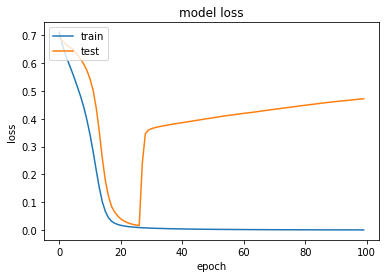

In [16]:
# plot history:
## summarize history for loss, from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

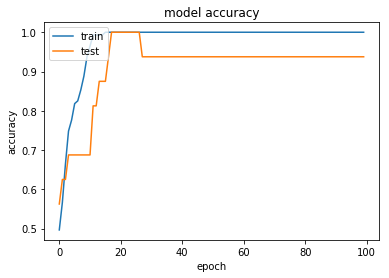

In [17]:
plt_metric(history, 'accuracy')